In [1]:
from liblet import ANTLR, Stack, Tree, __version__

__version__

'0.12.1-alpha'

# Occhio a ricorsione e precedenza

## Operatori aritmetici

In [2]:
expr = '1 + 2 * 3'

In [3]:
MulProd = ANTLR(r"""
grammar MulProd; ignoblebug: expr;
 
expr: expr '*' expr
    | expr '+' expr
    | NUM
    ;

NUM: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
""")

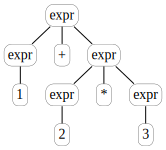

In [4]:
multprod_parse_tree = MulProd.tree(expr, 'expr', True)
multprod_parse_tree

In [5]:
MulProdWrong = ANTLR(r"""
grammar MulPordWrong; ignoblebug: expr;
 
expr: expr '+' expr
    | expr '*' expr
    | NUM
    ;

NUM: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
""")

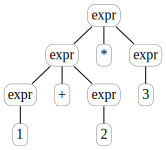

In [6]:
MulProdWrong.tree(expr, 'expr', True)

## Dangling else

In [7]:
source = r"""
if e0 then
    if e1 then
        i0
    else
        i1
"""

LEXER = r"""
ISTR: 'i' [0-9]* ;
EXPR: 'e' [0-9]* ;
WS: [ \t\n\r]+ -> skip ;
"""

In [8]:
IfElse = ANTLR(r"""
grammar IfElse;

stat:   'if' EXPR 'then' stat
    |   'if' EXPR 'then' stat 'else' stat
    |   ISTR
    ;
    
""" + LEXER)

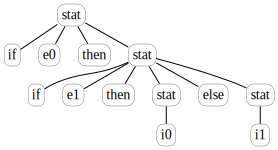

In [9]:
IfElse.tree(source, 'stat', True)

In [10]:
IfElseWrong = ANTLR(r"""
grammar IfElseWrong;

stat:   'if' EXPR 'then' stat 'else' stat
    |   'if' EXPR 'then' stat
    |   ISTR
    ;
    
""" + LEXER)

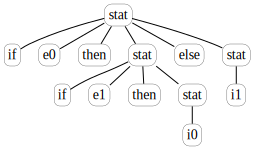

In [11]:
IfElseWrong.tree(source, 'stat', True)

In [12]:
IfElse = ANTLR(r"""
grammar IfElse;

stat:   'if' EXPR 'then' stat ('else' stat)?
    |   ISTR
    ;
    
""" + LEXER)

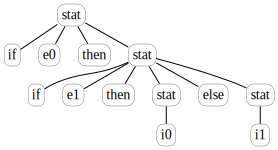

In [13]:
IfElse.tree(source, 'stat', True)

# Raccogliere informazioni

## Nei nodi

Alberi con *attributi*

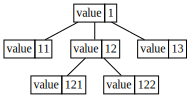

In [14]:
tree = Tree.from_lol(
    [{'value': 1}, 
           [{'value': 11}], 
           [{'value': 12}, 
               [{'value': 121}], 
               [{'value': 122}]
           ], 
           [{'value': 13}]
       ]
)
tree

### Ededitati

I sottoalberti ricevono il valore dalla radice (tramite una visita in pre-ordine).

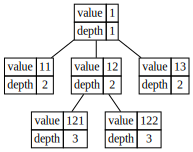

In [15]:
def update_depth(parent, tree):
    tree.root['depth'] = parent.root['depth'] + 1
    for child in tree.children: update_depth(tree, child)

update_depth(Tree({'depth': 0}), tree)        
tree

### Derivati, o sintetizzati

La radice deriva l'attributo da quelli dei sottoalberi (tramite una visita in post-ordine).

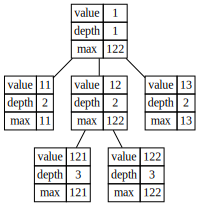

In [16]:
def update_max(tree):
    if not tree.children: tree.root['max'] = int(tree.root['value'])
    else:
        for child in tree.children: update_max(child)
        tree.root['max'] = max(child.root['max'] for child in tree.children)

update_max(tree)
tree

## In strutture dati esterne

Le informazioni non sono contenute nei nodi, ma in una struttura dati globale.

In [17]:
ODD_MAX_NODES = []

def update_ovn(tree):
    if tree.root['max'] % 2 == 1: ODD_MAX_NODES.append(tree.root)
    for child in tree.children: update_ovn(child)
        
update_ovn(tree)

ODD_MAX_NODES

[{'value': 11, 'depth': 2, 'max': 11},
 {'value': 121, 'depth': 3, 'max': 121},
 {'value': 13, 'depth': 2, 'max': 13}]

# Parse Tree e Abstract Syntax Tree

Il *parse tree* è il risultato del parsing, l'*AST* è un albero (annotato) che descrive più fedelmente la "semantica" che attribuiamo al linguaggio.

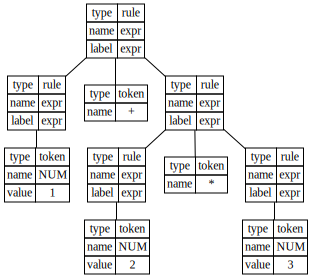

In [18]:
# parse tree

multprod_parse_tree = MulProd.tree(expr, 'expr')
multprod_parse_tree

## AST dal Parse Tree

In [19]:
def to_ast(tree):
    if tree.children[0].root['type'] == 'token':
        return Tree({'type': 'const', 'value': int(tree.children[0].root['value'])})
    left, op, right = tree.children
    return Tree({'type': 'op', 'kind': op.root['name']}, [to_ast(left), to_ast(right)])

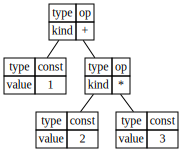

In [20]:
multprod_ast = to_ast(multprod_parse_tree)    
multprod_ast

## AST durante il parsing

Oltre che ottenerlo dal parse tree, si può costruire durante il parsing (gestendo a mano uno stack… **orrore**)

In [21]:
MulPordAST = ANTLR(r"""
grammar MulPordAST; 

@header {
from liblet import Stack 
}

@members {
    self.STACK = Stack()
}

ignoblebug: expr;

expr: expr '*' expr {self.STACK.push([{'type': 'op', 'kind': '*'}, self.STACK.pop(), self.STACK.pop()])}
    | expr '+' expr {self.STACK.push([{'type': 'op', 'kind': '+'}, self.STACK.pop(), self.STACK.pop()])}
    | NUM {self.STACK.push([{'type': 'const', 'value': $NUM.int}])}
    ;

NUM: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
""")

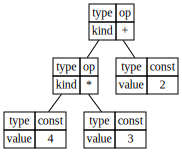

In [22]:
r = MulPordAST.context('2 + 3 * 4', 'expr', build_parse_trees = False)
multprod_ast = Tree.from_lol(r.parser.STACK.pop())
multprod_ast

# Usare l'AST

## Annotando

In [23]:
# il valore è sintetizzato, quindi uso una visita in post-ordine

def update_value(tree):
    if tree.root['type'] == 'op':
        left, right = tree.children
        update_value(left)
        update_value(right)
        if tree.root['kind'] == '+':
            tree.root['value'] = left.root['value'] + right.root['value']
        else:
            tree.root['value'] = left.root['value'] * right.root['value']
        
update_value(multprod_ast)
multprod_ast.root['value']

14

## Usando una struttura dati esterna

In [24]:
STACK = Stack()

def expr_eval(tree):
    if tree.root['type'] == 'op':
        left, right = tree.children
        expr_eval(left)
        expr_eval(right)
        if tree.root['kind'] == '+':
            STACK.push(STACK.pop() + STACK.pop())
        else:
            STACK.push(STACK.pop() * STACK.pop())
    else:
        STACK.push(tree.root['value'])

expr_eval(multprod_ast)
STACK.pop()

14